### Import and Settings

In [1]:
import cv2
import numpy as np
import os
import math
import tensorflow as tf
import idx2numpy as idx
import time
import pytesseract
import string
import color_normalization as cn
import matplotlib.pyplot as plt

# from matplotlib import pyplot as plt       # чтобы выводить промежуточные фото в jupyter
from PIL import Image
from tensorflow import keras
from keras.models import Sequential
from keras import optimizers
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense, Reshape, LSTM, BatchNormalization, RandomZoom, RandomRotation, Rescaling, Resizing
from keras.optimizers import SGD, RMSprop, Adam
from keras import backend as K
from keras.constraints import maxnorm
from keras.preprocessing.image import ImageDataGenerator # Для аугментаци (устаревший способ, TF рекомендует добавить слой препроцессинга в модель)
from datetime import datetime
from datetime import timedelta

# Список всех настроечных параметров/констант
WORK_DIR = 'pass_photos'
TEMP_DIR = 'pass_temp'
MODELS_DIR = 'models'

#DATASET_IMG = r'D:\work\test_comp_vision\datasets\!_lines_w25_dataset_images_100k_upper2.idx'
#DATASET_CLS = r'D:\work\test_comp_vision\datasets\!_lines_w25_dataset_classes_100k_upper2.idx'

DS_TRAIN_IMG = r"D:\work\test_comp_vision\datasets\!_lines_w25_parsed_norm_TRAIN_125000_UPPER_CHAR_FIXED_COLOR_NORM_images.idx"
DS_TRAIN_LBL = r"D:\work\test_comp_vision\datasets\!_lines_w25_parsed_norm_TRAIN_125000_UPPER_CHAR_FIXED_COLOR_NORM_labels.idx"
DS_VALID_IMG = r"D:\work\test_comp_vision\datasets\!_lines_w25_parsed_norm_VALID_25000_UPPER_CHAR_FIXED_COLOR_NORM_images.idx"
DS_VALID_LBL = r"D:\work\test_comp_vision\datasets\!_lines_w25_parsed_norm_VALID_25000_UPPER_CHAR_FIXED_COLOR_NORM_labels.idx"
DS_TEST_IMG = r"D:\work\test_comp_vision\datasets\!_lines_w25_parsed_norm_TEST_25000_UPPER_CHAR_FIXED_COLOR_NORM_images.idx"
DS_TEST_LBL = r"D:\work\test_comp_vision\datasets\!_lines_w25_parsed_norm_TEST_25000_UPPER_CHAR_FIXED_COLOR_NORM_labels.idx"

SAVED_MODEL_NAME = 'ru_letters_125k_b64_e25_16pxMode_loss_0.14_acc_0.96.h5'
# TEST_FILE = 'pass_photos/1.jpeg'
IMG_HEIGHT = 1000            # требуемый размер фото для нормализации всех изображений
IMG_WIDTH = 600              # т.к. в задачу входит прочитать только ФИО, обрезаю серию/номер чтобы не усложнять распознавание
INDENT_LEFT = 220            # обрезаем фото т.к. без него получается лучше разделить фото на куски текста
INDENT_TOP = 40              # обрезаем лишнюю часть паспорта снизу
INDENT_BOTTOM = 120          # обрезаем нижние поля
SCALE_FACTOR = 1             # во сколько раз увеличиваем вырезанные слова для дальнейшей обработки букв
DATASET_SYMBOL_SIZE = 28     # размер изображений в тренировочном датасете
MODEL_SYMBOL_SIZE = 14       # т.к. распознаваемые фото имеют низкое разрешение - проще обучить модель на низком разрешении 
# LABELS = '0123456789АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдеёжзийклмнопрстуфхцчшщъыьэюя'
LABELS = 'АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ'   # for test 2
SYMBOLS_COUNT = len(LABELS)  # количество символов в датасете: 33 + 33 + 10 (заглавные, строчные, цифры)
SYMBOLS_MARGIN_X = 0.075       # это обозначает добавление полей вокруг текста шириной 7.5% от размера буквы слева/справа
SYMBOLS_MARGIN_Y = 0.1       # это обозначает добавление полей вокруг текста шириной 10% от размера буквы сверху/снизу
LANG = 'rus'                        # Язык для распознавания текста (Tesseract OCR)
PSM = 6                             # Page Segmentation Mode (--psm). Больше информации в Tesseract --help
OEM = 3                             # Engine Mode (--oem). Больше информации в Tesseract --help

### Functions for detection

In [2]:
def get_files(directory: str) -> list:
    # Функция для получения списка файлов из каталога с фотографиями (как в task_1 и task_2)
    # TODO: переделать функцию, чтобы принимала в кач-ве параметра regex с перечислением искомых расширений файла
    names = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpeg") or filename.endswith(".jpg") or filename.endswith(".png"):
            names.append(os.path.join(directory, filename))
    return names


def scale_image(image, scale):     # принимаем объект изображения OpenCV
    # Масштабирование изображения
    # получаем текущий размер, вычисляем искомый и создаем измененное изображение
    height, width = image.shape[0], image.shape[1]
    new_width = int(width * scale)
    new_height = int(height * scale)
    # img = cv2.resize(image, (new_width, new_height))
    img = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_NEAREST) # рекомендуют, но качество страдает
    return img


# TODO - это не пригодилось. Зря переусложнено. Но возможно без него я и получаю ошибку при распознавании
def normalize_img_size(image, size):
    h, w = image.shape[0], image.shape[1]     # сначала передается высота, потом ширина
    size_max = max(w, h)
    letter_square = 255 * np.ones(shape=[size_max, size_max], dtype=np.uint8)
    if w > h:
        y_pos = size_max//2 - h//2
        letter_square[y_pos:y_pos + h, 0:w] = letter_crop
    elif w < h:
        x_pos = size_max//2 - w//2
        letter_square[0:h, x_pos:x_pos + w] = letter_crop
    else:
        letter_square = letter_crop
    # Resize letter to 28x28 and add letter and its X-coordinate
    letters.append((x, w, cv2.resize(letter_square, (out_size, out_size), interpolation=cv2.INTER_AREA)))
        

def cut_passport_info_area(image):     # принимаем объект изображения OpenCV
    # Нормализация размеров фотографии паспорта и вырезка нужной части для обработки
    # нормализуем фото к нужному размеру
    old_height = image.shape[0]     # получаем исходную высоту
    resize_scale = IMG_HEIGHT / old_height       # считаем коэффициент масштабирования изображения до требуемого
    # TODO - заменить использование отдельной функции на стандартный cv2.resize()
    img = scale_image(image=image, scale=resize_scale)
    new_width = img.shape[1]      # получаем новую ширину
    
    # обрезаем паспорт до страницы с фото
    x0 = INDENT_LEFT                            # отступ слева, т.к. корочка и фото нам не важны
    y0 = IMG_HEIGHT // 2 + INDENT_TOP           # обрезка сверху, т.к. верхняя страница с местом выдачи нам не важна 
    x1 = new_width if new_width < IMG_WIDTH else IMG_WIDTH   # обрезаем все лишнее справа, если есть разворот с пропиской
    y1 = IMG_HEIGHT - INDENT_BOTTOM
    img = img[y0:y1, x0:x1]              # сохраняем вырезанный кусок изображения для передачи
    
    #dim = (img.shape[1]*2, img.shape[0]*2)
    #img = cv2.resize(img, dim)  # 3
    
    return img

def set_gamma_corr(image, gamma=0.4):
    # gamma-correction:
    # O = ((I / 255) ** gamma )* 255
    # when gamma [0.0-100.0] and if gamma < 0 then dark regions will be brighter and has more detale
    lookup_table = np.empty((1,256), np.uint8)
    for i in range(256):
        lookup_table[0,i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)
    return cv2.LUT(image, lookup_table)

    # The function addWeighted calculates the weighted sum of two arrays
    #cal = cv2.addWeighted(cal, Alpha, cal, 0, Gamma)
    


def set_bright_cont(image, alpha=1.0, beta=0):
    # when `alpha` [1.0-3.0] is contrast scale and `beta` [0-100] is brightness scale
    # g(i,j) = alpha * g(i,j) + beta - for every pixels of image:
    return cv2.convertScaleAbs(image, alpha=alpha, beta=beta)


def normalize_color(image):         # принимаем объект изображения OpenCV
    # Подготовка изображений для распознавания текста
    # обесцвечиваем, если картинка цветная
    if len(image.shape) > 2:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)    # преобразуем в ЧБ
    else:
        gray = image
    
    # Размытие для снижения количества шумов. Эксперимент показал, что без него буквы детектируются лучше
    blur = cv2.GaussianBlur(gray, (3,3), 0)         # коэффициент размытия подобран вручную
    
    # Очередность преобраозвания найдена опытным путем
    # TODO - при распознавании преобразуем в uint32, возможно и здесь стоит
    kernel_block = np.ones((5,5), 'uint8')
    kernel_gray = np.ones((3,3), 'uint8')  
    # kernel = np.ones((5,5), 'uint16')   # не дал улучшения результата. при 'uint32' - код падает из-за ошибки разрешения
    # kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))  # не знаю в чем разница, но так работает хуже
    
    # В теории erode - делает буквы тоньше, а dilate - толще: https://docs.opencv.org/3.4/db/df6/tutorial_erosion_dilatation.html
    img_block = cv2.erode(blur, kernel_block, iterations=1)   # Но на практике "жирность" букв при этой операции повышается
    # img_block = cv2.dilate(gray, kernel_gray, iterations=1)  # А тут - наоборот
    # gray = cv2.convertScaleAbs(gray, alpha=alpha, beta=beta)
    # gray = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 33, 15)
    # _, gray = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    
    # TODO - поиграться с настройками, чтобы выдавать на выход именно контраст. Сейчас это только для детекции границ букв
    _, img_block = cv2.threshold(img_block, 0, 255, cv2.THRESH_OTSU, cv2.THRESH_BINARY_INV) # Повышаем контраст
    img_block = cv2.morphologyEx(img_block, cv2.MORPH_OPEN, kernel_block, iterations=1) # Снижаем шум на фоне
    # img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    
    """
    # Попытка найти лучший вариант детекции и выходного изображения. Оставил для дальнейших тестов
    # Grayscale, Gaussian blur, Otsu's threshold
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Morph open to remove noise and invert image
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=1)
    erosion = cv2.erode(gray, kernel, iterations = 1)
    dilation = cv2.dilate(gray, kernel, iterations = 1)
    invert = 255 - closing
    
    # Повышение контраста
    if len(image.shape) > 2:
        imghsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        imghsv[:,:,2] = [[max(pixel - 25, 0) if pixel < 190 else min(pixel + 25, 255) for pixel in row] for row in imghsv[:,:,2]]
        contrast = cv2.cvtColor(imghsv, cv2.COLOR_HSV2BGR)
        gray_contrast = cv2.cvtColor(contrast, cv2.COLOR_BGR2GRAY)    # преобразуем в ЧБ
        
    # при коэффициенте 3 - лучше распознается Васлевский, при 5 - Соколов и Юмакаева
    img_symbol = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 3, 2)
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_TOZERO+cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    """
    return img_block, gray      # Возвращаем контрастную картинку с разбивкой на блоки и простое ЧБ изображение


def search_blocks(image, limit: int, sort_by: str, sort_reverse=False):
    # Выделяем элементы текста из изображения
    #::limit:: - необходим чтобы указать на сколько мелкие символы нам не нужно распознавать
    
    height, width = image.shape[0], image.shape[1]
    # получаем контуры больших пятен на изображении, внутри которых спрятан текст
    contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    # contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) # другая вариация
    
    # print(f'Count of Block counoturs: {len(contours)}')
    blocks = []
    for idx, contour in enumerate(contours):
        (x, y, w, h) = cv2.boundingRect(contour)
        # print("R", x, y, w, h, hierarchy[0][idx])
        # hierarchy[i][0]: следующий контур текущего уровня
        # hierarchy[i][1]: предыдущий контур текущего уровня
        # hierarchy[i][2]: первый вложенный элемент
        # hierarchy[i][3]: родительский элемент
        # if hierarchy[0][idx][3] == 0:               # если элемент не является самым крупным
        # cv2.rectangle(image, (x, y), (x + w, y + h), (70, 0, 0), 1) # для контрольной картинки
        
        if limit < h < height and limit < w < width:    # игнорируем маленькие блоки, а также блок размером с изображение
            block = image[y:y + h, x:x + w]     # вырезаем найденный блок из изображения
            
            # сохраняем габариты и изображение блока в список блоков. Загоняем в словарь, чтобы проще сортировать
            # todo: По 'x' мы определяем очередность букв, ведь чем "левее буква", тем меньше ее 'x'. Также можно по 'y'
            blocks.append({'idx': idx, 'y': y, 'h': h, 'x': x, 'w': w, 'block': block})
    
    # Сортируем по нужному ключу: 'y' для вертикали или 'x' по горизонтали. Так же можно и по индексу или размерам
    blocks.sort(key=lambda x: x.get(sort_by), reverse=sort_reverse)
    # print(blocks)
    return blocks


def img_cut_blocks(image):
    """
    Больше не используется. Заменен функцией size_cut_blocks(), которая вместо изображения буквы принимает габариты буквы
    из которых уже определяет нужно ли делить ее на части. Дополнительно увеличивает зону вырезки буквы,
    чтобы добавить вокруг него пустое поле.
    """
    height, width = image.shape[0], image.shape[1]
    C = 1.2       # просто коэффициент, рассчитанный на широкие буквы вроде Ж, М, Ш и т.д., чтобы их не резало
    if width < height*C:
        # print(f'One symbol is True')
        return [image]
    else:
        # нам нужно увеличить 'h' и 'w' на 2 размера margin, после чего уменьшить 'x' и 'y' на один размер margin
        result = []
        y, h = 0, height      # высота и верхняя точке среза - всегда неизменны
        symbol_count = math.ceil(width / height)    # округляем символы до большего целого
        symbol_width = math.floor(width / symbol_count)   # округляем ширину в пикселях до меньшего целого
        
        for i in range(symbol_count):
            x = i * symbol_width
            result.append(image[y:h, x:x+symbol_width])
            # print(f'y = {y}, h = {h}, x = {x}, symbol_width = {x+symbol_width}, width = {width}')
            # print(f'symbol {i} is:\n{result[i]}')
            
        # print(f'Count of separeted symbols: {len(result)}')
        return result

    
def size_cut_blocks(x: int, w: int, y: int, h: int, C=1.2, margin_x=SYMBOLS_MARGIN_X, margin_y=SYMBOLS_MARGIN_Y) -> dict:
    """
    Если детектор букв выдает нам слишком "широкий" блок - значит он склеил несколько соседних букв.
    Это возможно по двум причинам:
    1. Плохое качество печати/изображения, тогда действительно соседние буквы сливаются даже для человеческого взгляда.
    2. Плохое качество фильтра определения границ букв. С этим еще нужно поработать - поковырять параметры в normalize_color()
    Выход - решать проблему математически (на вскидку). Если ширина больше высоты на определенную константу (подобрана руками)
    то делим изображение на расчетное количество элементов.
    Это не панацея, т.к. в зависимости от шрифта буква "Ж" может быть шире, чем сочетание "СТ". В таком случае при слишком
    малом коэффициенте - "Ж" разделится на 2 буквы, а при слишком большом - "СТ" останется склеенным.
    С английскими "ij" ситуация обстоит еще хуже.
    """
    # print([x, w, y, h])
    
    # высчитываем новые опорные точки изображения с учетом полей
    symbols_count = math.ceil(w / (h*C))    # округляем символы до большего целого
    #symbol_width = math.floor(w / symbols_count)   # округляем ширину в пикселях до меньшего целого
    symbol_width = math.ceil(w / symbols_count)   # округляем ширину в пикселях до большего целого
    
    new_x = x - int(symbol_width * margin_x)      # новый 'x' - это старый, уменьшенный на размер поля = 7.5% от ширины
    new_w = symbol_width + int(symbol_width * margin_x * 2)   # новый 'w' - это старый, увеличенный на двойной размер поля
    new_y = y - int(h * margin_y)                 # то же что 'x'
    new_h = h + int(h * margin_y * 2)             # то же что 'w'
    result = [[new_x], new_w, new_y, new_h]
    
    for i in range(1, symbols_count):     # цикл для расчета всех следующих 'x' в широких блоках
        # x += i * symbol_width         # для 0-го символа 'x' не меняется, для последующих увеличивается на расчетную ширину
        new_x = x + (i * symbol_width) - int(symbol_width * margin_x)   # новый 'x' - это старый, уменьшенный на размер поля = 7.5% от ширины
        result[0].append(new_x)
    
    # print(result)
    return result


def labels_to_int(labels=LABELS) -> dict:
    # Преобразуем букву в числвой код для создания классов в модели
    # TODO - можно вынести этот функционал в препроцессинговый слой модели - layers.StringLookup(output_mode="one_hot")
    label_nums = {}
    for i, lab in enumerate(labels):
        label_nums[lab] = i
    print(label_nums)
    return label_nums


labels_comparison = labels_to_int()     # получаем сопоставление символа к коду из датасета
labels_symbol = list(labels_comparison.keys())     # и получаем отдельно список по символам и кодам
labels_class = list(labels_comparison.values())


def predict_img(model, img):
    
    img = img.reshape((1, 28, 28, 1))

    predict = model.predict(img)
    result = np.argmax(predict, axis=1)     # получаем индекс класса с наибольшей предсказанной вероятностью
    
    #TODO изменить на использование словаря соответствия класса и буквы. сейчас тупо по индексу класса забираю букву
    #labels_symbol = list(labels_comparison.keys())
    
    print(labels_symbol[result[0]])
    return labels_symbol[result[0]]


def recognize_word(word_images_paths):
    # Эта функция целиком слово по заданному пути к изображению слова.
    # В текущей редакции код использует вместо этой функцию 'recognize_symbol'.
    word_images = []     # сюда собираем список всех картинок для одного слова
    predicted_word = ''

    # Если только что занимались созданием модели - будет запущена она. Если нет - будет запущена версия с диска  
    if 'model' in locals() or 'model' in globals():
        print("The model just created will be used.")
    else:
        try:
            print("The Model has not been created in the current session. Loading the saved model.")
            model = keras.models.load_model(MODEL_PATH)
        except NameError as ne:
            print(ne)
        except Exception as e:     # TODO Добавить обработку отсутствия файла
            print(e)

    # TODO - Переписать под использование картинок из кода выше, вместо исползования сохраненных на диск
    # Либо вынести в отдельную функцию забор картинок из папки, и в отдельную - запуск обработки полноценных изображений
    for letter_path in word_images_paths:
        #word_images.append(cv2.imread(letter_path))
        with Image.open(letter_path) as image:       # открываем картинку по ссылке, преобразуем в массив
            # img_to_arr = np.asarray(image)           # преобразуем загруженную картинку к необходимой Модели форме
            # img_to_arr = np.asarray([img_to_arr])    # требуется именно такое двойное преобразование 
            img_to_arr = np.asarray([np.asarray(image)])    # ТАК НАДО!!! Такова форма модели, иначе не работает
            print('\n', img_to_arr.shape)
            print(letter_path)
            #word_images.append(np.asarray(image))

            predicted_word += predict_img(model=model, img=img_to_arr)

    print(predicted_word)
    with open('task_3.txt', 'w') as f:
        f.write(predicted_word)

        
def recognize_symbol(model, symbol_img):
    img_to_arr = np.asarray([np.asarray(symbol_img)])    # ТАК НАДО!!! Такова форма модели, иначе не работает
    print('\n', img_to_arr.shape)

    return predict_img(model=model, img=img_to_arr)


def recognize_by_tesseract(img, lang=LANG, psm=PSM, oem=OEM) -> str:
    """ Распознаем текст с помощью Tesseract OCR
    В качестве изображения готовы принять объект PIL.Image, numpy.ndarray (при открытии через cv2.imread())
    или текстовый путь к изображению.
    """
    from PIL.JpegImagePlugin import JpegImageFile
    from PIL.PngImagePlugin import PngImageFile
    from numpy import ndarray
    
    config = f'--oem {oem} --psm {psm}'
    
    # В зависимости от переданного формата, приводим изображение к нужному для распознавания
    if isinstance(img, (JpegImageFile, PngImageFile)):
        # если передан объект типа PIL - используем его для распознавания
        image = img
        
    elif isinstance(img, ndarray):
        # если передан объект в формате numpy, значит использовался cv2, а значит необходимо преобразовать формат
        if len(img.shape) > 2:
            image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        else:
            image = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        
    elif isinstance(img, str):
        # если передана строка - вероятно это путь к файлу, а значит его необходимо загрузить
        # TODO - добавить проверку на существование файла
        image = Image.open(img)
    else:
        # TODO - заменить вывод текста на возврат ошибки и ее обработку.
        return f"""
        The function expects an PIL image, OpenCV image (numpy.ndarray) or a path to a file in a text format.
        Instead, another object is received. Check the passed value.
        """
    
    return pytesseract.image_to_string(image, lang=lang, config=config) + "\n"

{'А': 0, 'Б': 1, 'В': 2, 'Г': 3, 'Д': 4, 'Е': 5, 'Ё': 6, 'Ж': 7, 'З': 8, 'И': 9, 'Й': 10, 'К': 11, 'Л': 12, 'М': 13, 'Н': 14, 'О': 15, 'П': 16, 'Р': 17, 'С': 18, 'Т': 19, 'У': 20, 'Ф': 21, 'Х': 22, 'Ц': 23, 'Ч': 24, 'Ш': 25, 'Щ': 26, 'Ъ': 27, 'Ы': 28, 'Ь': 29, 'Э': 30, 'Ю': 31, 'Я': 32}


## Готовим модель и train/test

In [3]:
# Подгатавливаем модель для распознавания букв из датасетов по аналогии с EMNIST

# TODO - вместо подгонки данных перед отправкой на распознавание, нужно добавить этот слой непосредственно в модель
"""
resize_and_rescale = Sequential([
    layers.Resizing(DATASET_SYMBOL_SIZE, DATASET_SYMBOL_SIZE),
    layers.Rescaling(1./255)
])
"""

# does not use.
def augment(image, label, seed=0):
    #image, label = image_label
    #image, label = resize_and_rescale(image, label)
    #image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6)
    # Make a new seed.
    new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
    # Random crop back to the original size.
    #image = tf.image.stateless_random_crop(
    #image, size=[IMG_SIZE, IMG_SIZE, 3], seed=seed)
    # Random brightness.
    image = tf.image.stateless_random_brightness(image, max_delta=0.5, seed=new_seed)
    # Random contrast.
    image = tf.image.stateless_random_contrast(image, lower=0.1, upper=0.9, seed=new_seed)
    image = tf.clip_by_value(image, 0, 1)
    return image, label


def main_model(symbol_size=MODEL_SYMBOL_SIZE, number_of_classes=len(LABELS)):
    model = Sequential()
    
    # Аугментация ТЕСТОВЫХ данных. Преобразование цвета не имеет смысла, если мы нормализуем входящие изображения
    # model.add(RandomContrast(factor=0.25)) # Аугментация контраста +/- 50%. В теории вместо этого можно нормализвать изображение
    model.add(RandomRotation(factor=0.02, fill_mode="nearest")) # 0.02 * 2pi = 2% от 360 градусов, ~7.2 градуса к повороту тренировочных данных
    model.add(RandomZoom(height_factor=(-0.2, 0.0), width_factor=(-0.2, 0.0), fill_mode='nearest'))
    
    # Предобработка изображений для обучения и распознавания модели. Это нужно, чтобы не подгонять до отправки в модель
    model.add(Resizing(symbol_size, symbol_size))
    model.add(Rescaling(1./255))  # нормализация входных данных (как тренировочных, так и предсказываемх)
    #model.add(Rescaling(scale=1./127.5, offset=-1))  # сравнить с такой нормализацией
    
    # Основная модель.
    # Можно добавить слои BatchNormalization() между всеми слоями, что позволит нормализовать данные между ними
    # https://evileg.com/ru/post/619/
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), padding='valid',
                            input_shape=(symbol_size, symbol_size, 1), activation='relu'))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    # model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    # model.add(BatchNormalization())
    model.add(Dense(number_of_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
    
    # print(model.summary())
    return model

## Загружаем датасет и разбиваем на train/test

In [4]:
# Загружаем датасет Часть 1 / 2
TRAIN_SHARE = 0.7       # доля тренировочных данных = 75%
VALID_SHARE = (1 - TRAIN_SHARE) / 2     # доля валидационных данных - это половина от 100% минус тренировочные данные

# Загружаем датасеты картинок и их классов
#ds_images = idx.convert_from_file(DATASET_IMG)
#ds_classes = idx.convert_from_file(DATASET_CLS)

#train_slice = int(TRAIN_SHARE*len(ds_images))   # получаем границу для вырезки тренировочных данных
#valid_slice = train_slice + int(VALID_SHARE*len(ds_images))  # получаем границу для вырезки валидационных данных
#X_train, X_valid, X_test = np.split(ds_images, [train_slice, valid_slice])
#y_train, y_valid, y_test = np.split(ds_classes, [train_slice, valid_slice])


# Датасет с разбивкой на train, valid и test
X_train = idx.convert_from_file(DS_TRAIN_IMG)
y_train = idx.convert_from_file(DS_TRAIN_LBL)
X_valid = idx.convert_from_file(DS_VALID_IMG)
y_valid = idx.convert_from_file(DS_VALID_LBL)
X_test = idx.convert_from_file(DS_TEST_IMG)
y_test = idx.convert_from_file(DS_TEST_LBL)


print(f"X_train: {X_train.shape}")
print(f"X_valid: {X_valid.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_valid: {y_valid.shape}")
print(f"y_test: {y_test.shape}")


#print(train_slice)
#print(valid_slice)

X_train: (125000, 28, 28)
X_valid: (25000, 28, 28)
X_test: (25000, 28, 28)
y_train: (125000,)
y_valid: (25000,)
y_test: (25000,)


In [5]:
# Загружаем датасет Часть 2 / 2

# зачем-то предлагают сделать решейп датасета картинок, добавляя к слою изображения еще одно измерение
# такой же решейп предлагается для отправляемого в готовую модель изображения. хз надо ли это делать тут и там
# TODO - заменить предварительную обработку изображений на  предобработку непосредственно в первых слоях модели
X_train = np.reshape(X_train, (X_train.shape[0], 28, 28, 1))
X_valid = np.reshape(X_valid, (X_valid.shape[0], 28, 28, 1))
X_test = np.reshape(X_test, (X_test.shape[0], 28, 28, 1))

# Это тупо уменьшаем выборку из датасетов в 10 раз
#k = 10
#X_train = X_train[:X_train.shape[0] // k]
#y_train = y_train[:y_train.shape[0] // k]
#X_test = X_test[:X_test.shape[0] // k]
#y_test = y_test[:y_test.shape[0] // k]

# Нормализация изображений в датасете. Заменяет нам корректировку яркости и контраста. Темное к 0.0, светлое - к 1.0
# Реализовал нормализацию в первом слое самой модели, поэтому предварительная операция не требуется
"""
X_train = X_train.astype(np.float32)
X_train /= 255.0
X_valid = X_valid.astype(np.float32)
X_valid /= 255.0
X_test = X_test.astype(np.float32)
X_test /= 255.0
"""

# "маска" на которую будут созданы предсказание категорий
# TODO - перенести преобразование y_train/y_test к категорийному представлению - в слои препроцессинга модели
# TODO - можно пересохранить y_train, y_valid, y_test вместо создания новых категорийных переменных
y_train_cat = keras.utils.to_categorical(y_train, len(labels_comparison))    ### Вот так распознавание работает!!!
y_valid_cat = keras.utils.to_categorical(y_valid, len(labels_comparison))
y_test_cat = keras.utils.to_categorical(y_test, len(labels_comparison))

print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape, len(labels_comparison))
print(y_train_cat.shape, y_valid_cat.shape, y_test_cat.shape)

# Генератор аугментации для добавления разных вариантов яркости и контраста в изображения
# TODO - этот класс `depricated`, поэтому необходимо переписать аугментацию новым способом (с добавлением в модель)
# Кроме того эксперименты показали, что его использование сводит на нет сходимость модели. То ли я неверно его использую,
# то ли оно работает плохо.
datagen = ImageDataGenerator(
    brightness_range=[0.2, 1.2], # Диапазон яркости
    #rescale=1/255.,   # тут это не нужно, т.к. уже делаем нормализацию при загрузке Датасета.
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    #rotation_range=5,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #validation_split=0.15)   # Вероятно, аугментация валидационных данных приводит к тому, что модель не сходится
)
#datagen_train = datagen.flow(X_train, y_train_cat, subset='training')
#dataget_valid = datagen.flow(X_train, y_train_cat, subset='validation', class_mode='categorical') # class_mode доступен для .fit()

(125000, 28, 28, 1) (125000,) (25000, 28, 28, 1) (25000,) (25000, 28, 28, 1) (25000,) 33
(125000, 33) (25000, 33) (25000, 33)


## Обучаем модель на датасете

====== Start Model.fit() ======
Epoch 1/5
1954/1954 [==============================] - 60s 30ms/step - loss: 3.3464 - accuracy: 0.1305 - val_loss: 3.1652 - val_accuracy: 0.2613 - lr: 0.0010
Epoch 2/5
1954/1954 [==============================] - 58s 30ms/step - loss: 3.0687 - accuracy: 0.2012 - val_loss: 2.9203 - val_accuracy: 0.2613 - lr: 0.0010
Epoch 3/5
1954/1954 [==============================] - 57s 29ms/step - loss: 2.8643 - accuracy: 0.2698 - val_loss: 2.7084 - val_accuracy: 0.2613 - lr: 0.0010
Epoch 4/5
1954/1954 [==============================] - 59s 30ms/step - loss: 2.6475 - accuracy: 0.3526 - val_loss: 2.4561 - val_accuracy: 0.5198 - lr: 0.0010
Epoch 5/5
1954/1954 [==============================] - 57s 29ms/step - loss: 2.3843 - accuracy: 0.4361 - val_loss: 2.1625 - val_accuracy: 0.5294 - lr: 0.0010
====== Start Model.evaluate() ======
391/391 [==============================] - 3s 7ms/step - loss: 2.1657 - accuracy: 0.5213

Started at: 2023.01.08 12:42:07
Finished at: 2023.0

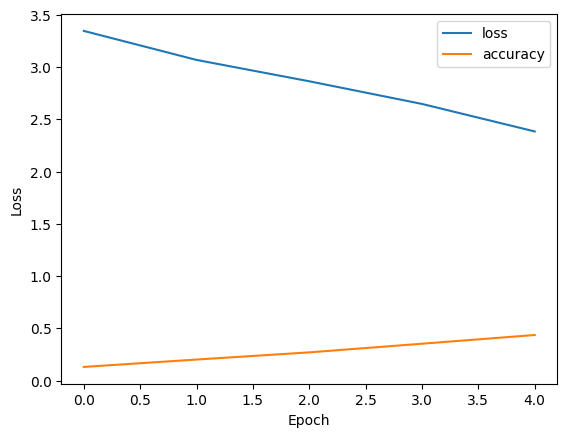

In [9]:
BATCH = 64
EPOCH = 5     # TODO - прописать функционал авто выхода из обучения, если качество не улучшается на протяжении 10 эпох
DT_PATTERN = ("%Y.%m.%d %H:%M:%S")   # шаблон для вывода даты и времени запуска и завершения обучения модели


"""
# Способ обучения модели по изображениям прямо в папке без создания отдельного датасета
# В нем же задаются настройки аугментации, которая расширяет общую базу изображений с учетом модификаций картинки
# Генерируем изображения
generator = datagen.flow_from_directory(
    'data/train', # Папка с изображениями для обучения
    target_size=(224, 224), # Размер изображений
    batch_size=BATCH, # Размер батча
    class_mode='categorical' # Категориальная классификация
)

# Обучаем модель
model.fit_generator(
    generator,
    steps_per_epoch=len(generator),
    epochs=10
)
"""

# TODO - протестировать запуск на 100+ эпох 1/10 часть датасета (10 тыс изображений) с аугментацией

# Set a learning rate reduction
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

# Загружаем в модель размер изображений и количество классов
model = main_model()

start_time = datetime.now()
print("====== Start Model.fit() ======")

"""
model.fit(datagen.flow(X_train, y_train_cat, batch_size=BATCH, subset='training'),
         validation_data=datagen.flow(X_test, y_test_cat, batch_size=BATCH, subset='validation'),
         steps_per_epoch=len(X_train) // BATCH, epochs=EPOCH)

model.fit(datagen.flow(X_train, y_train_cat, batch_size=BATCH),
          validation_data=(X_test, y_test_cat),
          callbacks=[learning_rate_reduction], batch_size=BATCH, epochs=EPOCH)
"""

# ТУТ ОТЛИЧНАЯ СКОРОСТЬ ОБУЧЕНИЯ ПРИ ИСПОЛЬЗОВАНИИ 2-Х АУГМЕНТИРУЮЩИХ СЛОЕВ В МОДЕЛИ
history = model.fit(X_train, y_train_cat, validation_data=(X_valid, y_valid_cat),
          callbacks=[learning_rate_reduction], batch_size=BATCH, epochs=EPOCH)

print("====== Start Model.evaluate() ======")
loss, accuracy = model.evaluate(X_test, y_test_cat, batch_size=BATCH)

model_name = f'ru_letters_{int(X_train.shape[0]//1000)}k_b{BATCH}_e{EPOCH}_16pxMode_loss_{round(loss, 2)}_acc_{round(accuracy, 2)}.h5'
model.save(os.path.join(MODELS_DIR, model_name))

finish_time = datetime.now()
runtime = finish_time - start_time

time_log = f"""
Started at: {start_time:{DT_PATTERN}}
Finished at: {finish_time:{DT_PATTERN}}
Total Runtime: {runtime}
Loss: {round(loss, 5)}
Accuracy: {round(accuracy, 5)}"""

print(time_log)
with open(f'{os.path.join(MODELS_DIR, model_name)}.txt', 'w') as f:
    f.write(time_log)
    
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['accuracy'], label="accuracy")
plt.legend()

## Детекция данных из паспорта и сохранение фоток букв в файлы

In [8]:
def passport_data_parser(work_dir: str, model, count=0):
    # Запускаем цикл по всем фото в рабочей папке
    try:     # TODO добавить проверку на существование файла
        passports = get_files(work_dir)
    except Exception as e:
        return e
     
    export_words = []
    if count > 0:
        count = min(count, len(passports))     # Что меньше - по такой индекс и забираем фотки (для тестов)
    else:
        count = len(passports)
    
    for id_p, passport in enumerate(passports[:count]):     # идем по списку путей к изображениям (ограничив длину списка)
        export_words.append([])                         # добавляем пустой список для заполнения данных паспорта
        temp_dir = os.path.join(TEMP_DIR, str(id_p))
        if not os.path.exists(temp_dir):
            os.mkdir(temp_dir)                              # создаем папку для сохранения промежуточных картинок

        print(f'==== Image {id_p}.jpg =====')
        image = cut_passport_info_area(cv2.imread(passport))     # получаем кусок паспорта с ФИО
        image = cn.normalize_img_color(image)   # нормализуем изображение - из диапазона [30-240] к [0-255], повышая контраст
        # imb_blocks - используем для детектирования слов, img_gray - используем для распознавания текста внутри блоков
        img_blocks, img_gray = normalize_color(image=image)      
        
        # TODO - убрать сохранение промежутоных файлов, они используются только для визуального контроля
        cv2.imwrite(f'{TEMP_DIR}/{id_p}_blocs.jpg', img_blocks)
        cv2.imwrite(f'{TEMP_DIR}/{id_p}_symbols.jpg', img_gray)

        words = search_blocks(image=img_blocks, limit=15, sort_by='y')   # ищем блоки на картинке с жирными буквами

        # получаем все обнаруженные слова из файла, в котором читаются символы
        for id_w, word in enumerate(words[:3]):    # можно забирать только первые 3 слова ФИО
            export_words[id_p].append([])      # добавляем вложенный список для каждого слова
            # из словаря обнаруженного блока текста забираем координаты и размер блока
            y, h, x, w = word['y'], word['h'], word['x'], word['w']
            
            img_word = img_gray[y:y + h, x:x + w]     # вырезаем слово из серой картинки по его координатам
            img_word = cn.normalize_img_color(img_word)
            # TODO - заменить использование отдельной функции на стандартный cv2.resize()
            #img_word = scale_image(img_word, SCALE_FACTOR)   # увеличиваем изображение, чтобы детектировать буквы
            #img_word = cn.normalize_img_color(img_word)
            
            #word_blocks, _ = normalize_color(image=img_word) # прогоняем через детектор увеличенное фото слова
            #symbols = search_blocks(image=word_blocks, limit=SCALE_FACTOR*10, sort_by='x')  # слева направо
            #kernel_of_dilate = np.ones((3,3), 'uint8')  
            #img_word = cv2.dilate(img_word, kernel_of_dilate, iterations=1)  # А тут - наоборот
            symbols = search_blocks(image=img_word, limit=SCALE_FACTOR*10, sort_by='x')  # слева направо
            
            #thresh = cv2.adaptiveThreshold(img_word, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 25, 11)
            #symbols = search_blocks(image=thresh, limit=SCALE_FACTOR*10, sort_by='x')  # слева направо
            
            # TODO - частичный повтор кода. Придумать как переделать, чтобы не дублировать функционал
            # При распознавании через Tesseract OCR весь этот цикл не используется
            for id_s, symbol in enumerate(symbols):
                # TODO - убрать сохранение промежутоных файлов, они используются только для визуального контроля
                word_dir = os.path.join(temp_dir, str(id_w))     # создаем очередную вложенную папку для котроля
                if not os.path.exists(word_dir):
                    os.mkdir(word_dir)

                x, w, y, h = symbol['x'], symbol['w'], symbol['y'], symbol['h']
                # cv2.rectangle(img_word, (x, y), (x+w, y+h), (70, 0, 0), 2) # для контрольной картинки
                temp_symbol = size_cut_blocks(x=x, w=w, y=y, h=h, C=1.2) # получаем [['x1', 'x2', ...], 'w', 'y', 'h']
                shape_y, shape_x = img_word.shape      # получаем размеры вырезанного слова, из которого извлекаем буквы
                
                for id_o, x_one_symbol in enumerate(temp_symbol[0]):
                    x1 = x_one_symbol
                    y1 = temp_symbol[2]
                    x2 = x1 + temp_symbol[1]      # x2 = x + w
                    y2 = y1 + temp_symbol[3]      # y2 = y + h
                    x1, y1 = max(x1, 0), max(y1, 0)   # если 'x1' и 'y1' имеют отрицательное значение - приравниваем к 0
                    x2 = min(x2, shape_x)   # если 'x2' больше, чем размер изображения - приравниваем к размеру изображения
                    y2 = min(y2, shape_y)   # аналогично 'x2'
                    one_symbol = img_word[y1:y2, x1:x2]
                    #one_symbol = word_blocks[y1:y2, x1:x2]   # кидаем на распознавание контрастное изображение вместо паспорта
                    #one_symbol = word_formatted[y1:y2, x1:x2]   # кидаем на распознавание контрастное изображение вместо паспорта
                    
                    # TODO - переписать убрав предварительное уменьшение картинки. Пусть этим занимается модель на входе.
                    one_symbol = cv2.resize(one_symbol, (DATASET_SYMBOL_SIZE, DATASET_SYMBOL_SIZE))
                    cv2.imwrite(os.path.join(word_dir, f'{id_s}-{id_o}.jpg'), one_symbol)
                    
                    # Основной вывод текста
                    export_words[id_p][id_w].append(recognize_symbol(model=model, symbol_img=one_symbol))
                    # cv2.rectangle(img_word, (x1, y1), (x2, y2), (0, 0, 150), 1) # для контрольной картинки
            
            cv2.imwrite(os.path.join(temp_dir, f'{id_w}_symbols.jpg'), img_word)   #сохраняем файлы только для контроля
            #cv2.imwrite(os.path.join(temp_dir, f'{id_w}_blocks.jpg'), word_blocks)   #сохраняем файлы только для контроля
            
            # Временный вывод текста с распознаванием через Tesseract OCR
            # recognized_text = recognize_by_tesseract(img_word)
            #recognized_text = recognized_text.translate({ord(c): None for c in string.whitespace}) # удаляем лишние пробелы
            #export_words[id_p][id_w].append(recognized_text)
            
                    
    return export_words

In [9]:
passports = get_files(WORK_DIR)
print(passports[:3])

['pass_photos\\0.jpeg', 'pass_photos\\1.jpeg', 'pass_photos\\10.jpg']


In [10]:
if 'model_name' in locals() or 'model_name' in globals():
    print("The model just created will be used.")
else:
    print("Early saved model will be used.")
    model_name = os.path.join(MODELS_DIR, SAVED_MODEL_NAME)

# TODO - тут потенциалная ошибка, если модель сохраняем в другом месте
model = keras.models.load_model(model_name)
symbols = passport_data_parser(work_dir=WORK_DIR, model=model, count=0)    # count=0 - значение по-умолчанию для распознавания всех
#symbols.append(passport_data_parser(work_dir=WORK_DIR, count=5))   # Для теста разбираем только 1 паспорт
#print(len(symbols[0]))

result = ''
for i_p, passport in enumerate(symbols):
    name_second = ''.join(symbols[i_p][0])
    name_first = ''.join(symbols[i_p][1])
    name_middle = ''.join(symbols[i_p][2])
    result += f'Паспорт: {i_p}:\nФамилия: {name_second}\nИмя: {name_first}\nОтчество {name_middle}\n\n'

with open ('task_3.txt', 'w') as f:
    f.write(result)

Early saved model will be used.
==== Image 0.jpg =====

 (1, 28, 28)
1/1 [==============================] - 0s 265ms/step
Т

 (1, 28, 28)
1/1 [==============================] - 0s 15ms/step
Р

 (1, 28, 28)
1/1 [==============================] - 0s 25ms/step
А

 (1, 28, 28)
1/1 [==============================] - 0s 13ms/step
Ы

 (1, 28, 28)
1/1 [==============================] - 0s 13ms/step
Д

 (1, 28, 28)
1/1 [==============================] - 0s 15ms/step
Д

 (1, 28, 28)
1/1 [==============================] - 0s 15ms/step
О

 (1, 28, 28)
1/1 [==============================] - 0s 25ms/step
Ц

 (1, 28, 28)
1/1 [==============================] - 0s 16ms/step
А

 (1, 28, 28)
1/1 [==============================] - 0s 13ms/step
Л

 (1, 28, 28)
1/1 [==============================] - 0s 15ms/step
А

 (1, 28, 28)
1/1 [==============================] - 0s 14ms/step
Д

 (1, 28, 28)
1/1 [==============================] - 0s 14ms/step
Л

 (1, 28, 28)
1/1 [==============================] - 0s 22ms

In [11]:
print(result)

Паспорт: 0:
Фамилия: ТРАЫД
Имя: ДОЦАЛАД
Отчество ЛАОВ

Паспорт: 1:
Фамилия: КМАЫКЛНОА
Имя: НТДИН
Отчество АЛГКСГГПОА

Паспорт: 2:
Фамилия: АДДЛГУ
Имя: ДДГЫОГ
Отчество АДАТМЙЫ

Паспорт: 3:
Фамилия: ААТОРДИАРРА
Имя: ДИАТОРЙД
Отчество ДЛАОЛААДВА

Паспорт: 4:
Фамилия: АААИ
Имя: ТЛТГТ
Отчество З

Паспорт: 5:
Фамилия: ОУООП
Имя: ААТНЯ
Отчество ЙОАТИЛ

Паспорт: 6:
Фамилия: ИКМЦЛВ
Имя: ГТИД
Отчество РРЫАОИЧ

Паспорт: 7:
Фамилия: ДАЯЗВДСКУВ
Имя: ЛЯЛСОРАВ
Отчество ДСТРОЛДЯ

Паспорт: 8:
Фамилия: ИПДРДА
Имя: РРЧАИЧААЯЯААВХ
Отчество АТАДТАКА

Паспорт: 9:
Фамилия: АУДАЛААЯЛ
Имя: АЧТМИАР
Отчество ВГТРХДЛЧ

Паспорт: 10:
Фамилия: ЯСРУЛУА
Имя: АЙ
Отчество АЫЬТГ




## Далее исключительно тесты механик, не влияющие на основной функционал. 

In [54]:
from tensorflow.keras.preprocessing import image
img = cv2.imread(r"D:\work\test_comp_vision\test_for_MindSet\pass_temp\0\0\3-0.jpg")

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# img_gamma = set_gamma_corr(image=img)
#img_uint8 = image.img_to_array(img, dtype='uint8')
#blur = cv2.medianBlur(img_uint8, 5)
# TODO - закомиттить в доку описание ошибки CV_8UC1. adaptive Threshold требует на вход изгбражение строкго gray!
# необходимо это описать либо в документации, либо в коде ошибки.
# cv2  error: (-215:Assertion failed) src.type() == CV_8UC1 in function 'cv::adaptiveThreshold'
tresh1 = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 9, 5)
#tresh2 = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 9, 7)
tresh3 = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 9, 9)
tresh4 = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 25, 9)
tresh5 = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 35, 9)
tresh6 = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 11)
tresh7 = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 25, 25)  # ФАВОРИТ

# cv2.imshow('Gamma 0.25', set_gamma_corr(image=img, gamma=0.25))
# cv2.imshow('Gamma 0.5', set_gamma_corr(image=img, gamma=0.5))
cv2.imshow('orig_image', img)
# cv2.imshow('Gamma 2.0', set_gamma_corr(image=img, gamma=2.0))
cv2.imshow('Contrast 1.5', cv2.convertScaleAbs(gray, alpha=1.5, beta=0))
#cv2.imshow('Contrast 1.75', cv2.convertScaleAbs(gray, alpha=1.75, beta=0))
cv2.imshow('TRESH 9, 5', tresh1)
#cv2.imshow('TRESH 9, 7', tresh2)
#cont = cv2.convertScaleAbs(gray, alpha=1.25, beta=0)
tresh8 = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 25, 11)
cv2.imshow('TRESH 25, 11', tresh8)
cv2.imshow('TRESH 25, 9', tresh4)
cv2.imshow('TRESH 35, 9', tresh5)
cv2.imshow('TRESH 11, 11', tresh6)
cv2.imshow('TRESH 25, 25', tresh7)

cv2.waitKey(0)  
# cv2.destroyAllwindows()

-1

In [58]:
from tensorflow.keras.preprocessing import image
img = cv2.imread(r"D:\work\test_comp_vision\test_for_MindSet\pass_temp\0\0\3-0.jpg")
scale_size = 0.5
dim1 = (int(img.shape[0]*scale_size), int(img.shape[1]*scale_size))
dim2 = (int(img.shape[0]*16), int(img.shape[1]*16))

inter1 = cv2.resize(img, dim1, interpolation = cv2.INTER_NEAREST) # 1
inter1 = cv2.resize(inter1, dim2, interpolation = cv2.INTER_NEAREST) # 1
inter3 = cv2.resize(img, dim1, interpolation = cv2.INTER_AREA)    # 2
inter3 = cv2.resize(inter3, dim2, interpolation = cv2.INTER_NEAREST) # 1
inter2 = cv2.resize(img, dim1, interpolation = cv2.INTER_LINEAR)  # 3
inter2 = cv2.resize(inter2, dim2, interpolation = cv2.INTER_NEAREST) # 1
#inter4 = cv2.resize(img, dim, interpolation = cv2.INTER_LINEAR_EXACT)
#inter5 = cv2.resize(img, dim, interpolation = cv2.INTER_NEAREST_EXACT)
#inter6 = cv2.resize(img, dim, interpolation = cv2.INTER_MAX)
#inter7 = cv2.resize(img, dim, interpolation = cv2.WARP_FILL_OUTLIERS)
#inter8 = cv2.resize(img, dim, interpolation = cv2.WARP_INVERSE_MAP)

#cv2.imshow('orig', img)
cv2.imshow('NEAREST', inter1)
cv2.imshow('AREA', inter2)
cv2.imshow('LINEAR', inter3)
#cv2.imshow('L_EXACT', inter4)
#cv2.imshow('N_EXACT', inter5)
#cv2.imshow('MAX', inter6)
#cv2.imshow('FILL_OUTLIERS', inter7)
#cv2.imshow('INVERSE_MAP', inter8)


cv2.waitKey(0)  

-1

bias (смещение) "хранится" в нейроне
wight (веса) "хранятся" в связях между нейронами
Поэтому мы имеем по весу на каждое соединение между нейронами текущего и предыдущего слоя
и одно смещение на каждый нейрон текущего слоя

1/1 [==============================] - 0s 63ms/step
[[209.95422]]


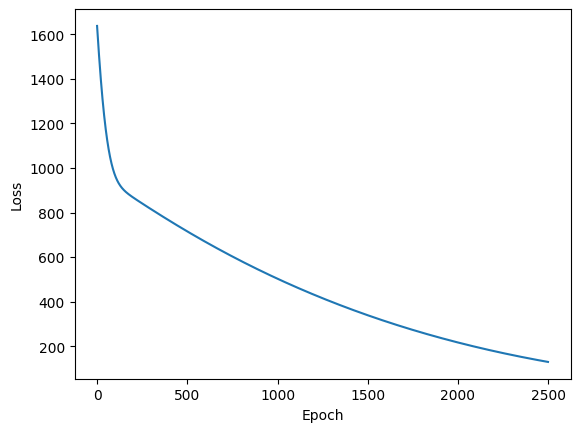

In [18]:
celsius_q    = np.array([-40, -10, 0, 8, 15, 22, 38], dtype=float)
fahrenheit_a = np.array([-40, 14, 32, 46, 59, 72, 100], dtype=float)

l0 = tf.keras.layers.Dense(units=1, input_shape=[1]) 
model = tf.keras.Sequential([l0])
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01))
history = model.fit(celsius_q, fahrenheit_a, epochs=2500, verbose=False)
print(model.predict([100.0]))

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history.history['loss'])
#plt.plot(history.history['accuracy'])
#plt.legend()